# Optuna: A Visual Review

### Environment Setup (dependencies + CUDA):

In [ ]:
# Install relevant libraries (may not be pre-installed);
!pip install pandas xgboost scikit-learn optuna jupyterlab-optuna catboost

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from itertools import product # Necessary for GridSearch;
import optuna
from catboost import CatBoostClassifier # CatBoost;
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset;
column_names = ["age", "workclass", "fnlwgt", "education", "education_num", 
                "marital_status", "occupation", "relationship", "race", 
                "sex", "capital_gain", "capital_loss", "hours_per_week", 
                "native_country", "income"]
df = pd.read_csv('/datasets/adult_uci/adult.data', header=None, names=column_names, na_values=' ?')

# <span style="color:blue">Demo</span>

<span style="color: purple">Please note that this document **does not include any analysis done on the plots or comment on the code outputs**, for this refer to the final report *(will be uploaded alongside this as a PDF)*. This notebook only contains the code for the outputs given in the report.</span>

Here I'll set up **CatBoost** with **Optuna**; remember that I am not attempting to get the best model possible, but rather *observe which hyperparameters **Optuna** chooses to optimise based on the given accuracies of each configuration*.

Please note that I will be evaluating according to a **train/test dataset** in an **80/20 split**. Please note that the data used here is the **UCI Adult dataset**, which may be found [here](https://archive.ics.uci.edu/dataset/2/adult):

In [5]:
# Data preprocessing: Handle missing values (drop rows with missing data for simplicity);
df = df.dropna()
# Split into features and target;
X = df.drop("income", axis=1)
# Transform the target variable 'income' to binary (<=50K: 0, >50K: 1);
label_encoder = LabelEncoder()
df['income'] = label_encoder.fit_transform(df['income'])
# Assign target variable;
y = df["income"]

# Identify categorical and numerical columns;
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
numerical_columns = X.select_dtypes(exclude=['object']).columns.tolist()
# Get indices of categorical columns (required for CatBoost);
cat_feature_indices = [X.columns.get_loc(col) for col in categorical_columns]
# Split into training and testing sets;
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# To store the optimization data for plotting;
trial_data_optuna = []
def objective(trial):
    # Define hyperparameters for tuning;
    iterations = trial.suggest_int('iterations', 50, 500)
    depth = trial.suggest_int('depth', 2, 11)
    bagging_temperature = trial.suggest_float('bagging_temperature', 0, 9)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1e-4, 1e-1, log=True)
    
    # Initialize CatBoost;
    model = CatBoostClassifier(
        iterations=iterations,
        depth=depth,
        bagging_temperature=bagging_temperature,
        learning_rate=learning_rate,
        l2_leaf_reg=l2_leaf_reg,
        task_type="GPU", # Enable GPU usage;
        devices='0' # Specify GPU device ID, usually '0' for the first GPU;
    )
    
    # Fit the model;
    model.fit(X_train, y_train, cat_features=cat_feature_indices, verbose=False)
    # Predict and calculate accuracy;
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Track hyperparameters and accuracy;
    trial_data_optuna.append({
        'iterations': iterations,
        'depth': depth,
        'bagging_temperature': bagging_temperature,
        'learning_rate': learning_rate,
        'l2_leaf_reg': l2_leaf_reg,
        'accuracy': accuracy
    })
    return accuracy

# Create Optuna study and optimize;
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=243) # 3^5 trials, for matching with Grid Search and its exhaustion;

# Best hyperparameters and associated results;
print("Best hyperparameters: ", study.best_params, ", with result: ", study.best_value)

[I 2024-10-30 19:31:47,537] A new study created in memory with name: no-name-d6185d61-b6b0-4595-bf73-4e9cc8c1cecd
[I 2024-10-30 19:32:10,739] Trial 0 finished with value: 0.8594397480523785 and parameters: {'iterations': 364, 'depth': 10, 'bagging_temperature': 4.0456284075915026, 'learning_rate': 0.003011245873801724, 'l2_leaf_reg': 0.08289031053315378}. Best is trial 0 with value: 0.8594397480523785.
[I 2024-10-30 19:32:14,550] Trial 1 finished with value: 0.8226421349245815 and parameters: {'iterations': 334, 'depth': 4, 'bagging_temperature': 8.279367080744839, 'learning_rate': 0.00013737738813953844, 'l2_leaf_reg': 0.0004366726478679979}. Best is trial 0 with value: 0.8594397480523785.
[I 2024-10-30 19:33:01,362] Trial 2 finished with value: 0.8476711420520471 and parameters: {'iterations': 413, 'depth': 11, 'bagging_temperature': 7.230435588851101, 'learning_rate': 0.010195774820840659, 'l2_leaf_reg': 0.009319552327132052}. Best is trial 0 with value: 0.8594397480523785.
[I 2024-

Best hyperparameters:  {'iterations': 463, 'depth': 4, 'bagging_temperature': 0.24169578913306594, 'learning_rate': 0.09450523744140935, 'l2_leaf_reg': 0.0007610514749397944} , with result:  0.8771755345599205


And now, I'm going to plot the **`trial_data_optuna`** array that we have been collecting from the **Optuna** trials; I'll also be defining a shared function to avoid constantly re-defining:

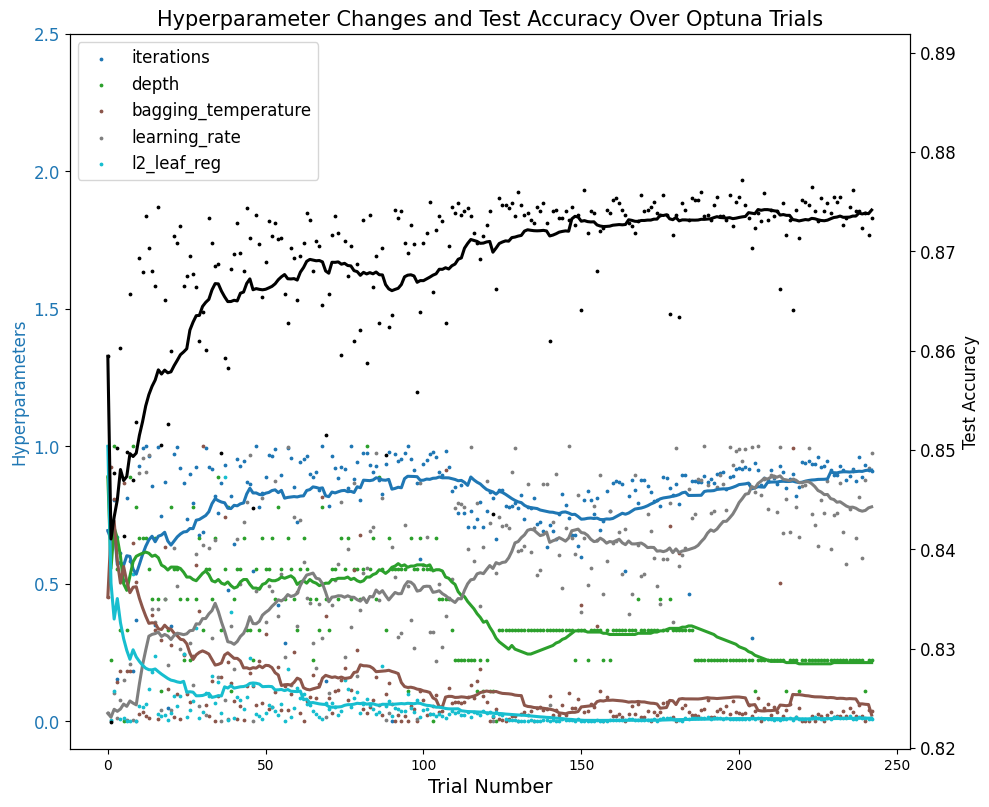

In [16]:
# Convert trial data into a pandas df;
def plot(title, showMovingAve, data):
    if showMovingAve:
        point_size = 3
    else:
        point_size = 4 # Larger when there is no moving average line;
    trial_df = pd.DataFrame(data)
    # Identify hyperparameters dynamically (exclude 'accruacy' and 'trial_number';
    hyperparams = [col for col in trial_df.columns if col not in ['accuracy', 'trial_number']]

    # Scale only the hyperparameter columns;
    scaler = MinMaxScaler()
    trial_df[hyperparams] = scaler.fit_transform(trial_df[hyperparams])

    # Add trial number for x-axis;
    trial_df['trial_number'] = range(len(trial_df))

    # Initialize plot;
    fig, ax1 = plt.subplots(figsize=(10, 8))
    # Plot each hyperparameter with dynamic colors and moving averages;
    colors = plt.cm.tab10(np.linspace(0, 1, len(hyperparams)))

    for i, hyperparam in enumerate(hyperparams):
        # Plot dot points;
        ax1.scatter(trial_df['trial_number'], trial_df[hyperparam], label=hyperparam, color=colors[i], s=point_size)
        # Plot moving average (window size = 15);
        if showMovingAve:
            ax1.plot(trial_df['trial_number'], trial_df[hyperparam].rolling(window=25, min_periods=1).mean(),
                    color=colors[i], linewidth=2.2)
    ax1.set_xlabel('Trial Number', fontsize=14)
    ax1.set_ylabel('Hyperparameters', color='tab:blue', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=12)
    ax1.legend(loc='upper left', fontsize=12)

    # Maintain original y-limits;
    ax1.set_ylim(-0.1, 2.5)

    # Plot accuracy on the right y-axis with black dots and moving average;
    ax2 = ax1.twinx()
    ax2.set_ylabel('Test Accuracy', color='#000000', fontsize=12)
    ax2.scatter(trial_df['trial_number'], trial_df['accuracy'], color='#000000', s=point_size, label='accuracy')
    if showMovingAve:
        ax2.plot(trial_df['trial_number'], trial_df['accuracy'].rolling(window=25, min_periods=1).mean(),
                 color='#000000', linewidth=2.2)
    ax2.tick_params(axis='y', labelcolor='#000000', labelsize=12)

    # Maintain original accuracy y-limits with a 20% stretch for readability;
    y_min, y_max = ax2.get_ylim()
    y_margin = 0.2 * (y_max - y_min)
    ax2.set_ylim(y_min, y_max + y_margin)
    ax2.tick_params(axis='y', labelcolor='#000000')

    # Finalise plot and show;
    fig.tight_layout()
    plt.title(title, fontsize=15)
    plt.show()
plot("Hyperparameter Changes and Test Accuracy Over Optuna Trials", True, trial_data_optuna)

Now, for the sake of comparison, I'll set up the same model with **Grid Search** instead of Optuna:

In [8]:
# Define hyperparameter grid with three discrete values per hyperparameter;
    # (low, medium, high values given here);
param_grid = {
    'iterations': [50, 175, 300], # Low, medium, high, but restricted till 300;
    'depth': [2, 6, 11],
    'bagging_temperature': [0, 4.5, 9],
    'learning_rate': [1e-4, 1e-2, 1e-1],
    'l2_leaf_reg': [1e-4, 5e-2, 1e-1]
}
# For a total of 3^5 or 243 hyperparameters;

# Convert param_grid into a list of all possible hyperparameter combinations;
param_combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())

# To store the optimization data for plotting;
trial_data_grid = []
# Iterate over each hyperparameter combination;
for i, params in enumerate(param_combinations):
    print(f"Trial {i}: ", params)
    # Unpack the parameter combination into a dictionary;
    param_dict = dict(zip(param_names, params))
    
    # Initialize the CatBoost model with the current set of hyperparameters;
    model = CatBoostClassifier(
        iterations=param_dict['iterations'],
        depth=param_dict['depth'],
        bagging_temperature=param_dict['bagging_temperature'],
        learning_rate=param_dict['learning_rate'],
        l2_leaf_reg=param_dict['l2_leaf_reg'],
        task_type="GPU",
        devices='0',
        verbose=False
    )
    # Train the model on the training data;
    model.fit(X_train, y_train, cat_features=cat_feature_indices)
    # NOTE: `cat_feature_indices` brought over from the "Optuna" code block;
    # Predict on the test set;
    y_test_pred = model.predict(X_test)
    # Calculate accuracy on the test set;
    accuracy = accuracy_score(y_test, y_test_pred)
    
    # Store the results;
    result = param_dict
    result['accuracy'] = accuracy
    trial_data_grid.append(result)
    
# Convert results to a df for analysis;
trial_df_grid = pd.DataFrame(trial_data_grid)
# Find the best hyperparameters and accuracy;
best_result = trial_df_grid.loc[trial_df_grid['accuracy'].idxmax()]
print("Best hyperparameters: ", best_result.drop('accuracy').to_dict(), ", with result: ", best_result['accuracy'])

Trial 0:  (50, 2, 0, 0.0001, 0.0001)
Trial 1:  (50, 2, 0, 0.0001, 0.05)
Trial 2:  (50, 2, 0, 0.0001, 0.1)
Trial 3:  (50, 2, 0, 0.01, 0.0001)
Trial 4:  (50, 2, 0, 0.01, 0.05)
Trial 5:  (50, 2, 0, 0.01, 0.1)
Trial 6:  (50, 2, 0, 0.1, 0.0001)
Trial 7:  (50, 2, 0, 0.1, 0.05)
Trial 8:  (50, 2, 0, 0.1, 0.1)
Trial 9:  (50, 2, 4.5, 0.0001, 0.0001)
Trial 10:  (50, 2, 4.5, 0.0001, 0.05)
Trial 11:  (50, 2, 4.5, 0.0001, 0.1)
Trial 12:  (50, 2, 4.5, 0.01, 0.0001)
Trial 13:  (50, 2, 4.5, 0.01, 0.05)
Trial 14:  (50, 2, 4.5, 0.01, 0.1)
Trial 15:  (50, 2, 4.5, 0.1, 0.0001)
Trial 16:  (50, 2, 4.5, 0.1, 0.05)
Trial 17:  (50, 2, 4.5, 0.1, 0.1)
Trial 18:  (50, 2, 9, 0.0001, 0.0001)
Trial 19:  (50, 2, 9, 0.0001, 0.05)
Trial 20:  (50, 2, 9, 0.0001, 0.1)
Trial 21:  (50, 2, 9, 0.01, 0.0001)
Trial 22:  (50, 2, 9, 0.01, 0.05)
Trial 23:  (50, 2, 9, 0.01, 0.1)
Trial 24:  (50, 2, 9, 0.1, 0.0001)
Trial 25:  (50, 2, 9, 0.1, 0.05)
Trial 26:  (50, 2, 9, 0.1, 0.1)
Trial 27:  (50, 6, 0, 0.0001, 0.0001)
Trial 28:  (50, 6,

**NOTE: I did not use `GridSearchCV` since that applies cross-validation instead of using the test/train split, so a more manual approach was taken instead. Please note that, theoretically speaking, the "exhaustion" observed here does not differ from the commonly used `GridSearchCV` method.**

Here is the plot for **Grid Search** collected through the **`trail_data_grid`** array *(shared function used for the plot from Optuna, except with different title and lack of moving average line/s)*:

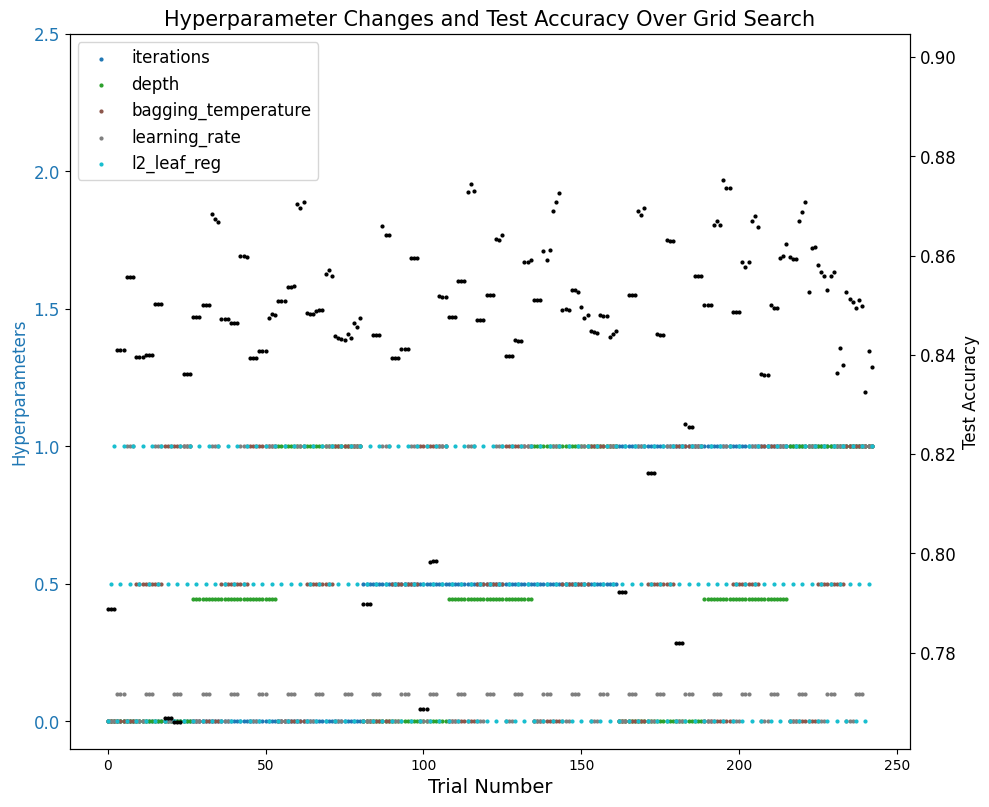

In [17]:
plot("Hyperparameter Changes and Test Accuracy Over Grid Search", False, trial_data_grid)

I'll also set up the same model with **Random Search** instead of Optuna. Once again a **manual approach** will be used here since the popular method **`RandomSearchCV`** utilises cross-validation, and we want to use a **train/test split**:

In [10]:
# Define hyperparameter distributions with ranges;
param_distributions = {
    'iterations': np.random.choice(np.linspace(50, 500, num=450, dtype=int), 243), # Random values within 50-500;
    'depth': np.random.choice(np.arange(2, 12), 243), # Random integer within 2-11;
    'bagging_temperature': np.random.choice(np.linspace(0, 9), 243), # Random from 0 to 9;
    'learning_rate': np.random.choice(np.logspace(-4, -1, num=100), 243), # Log scale for learning rate;
    'l2_leaf_reg': np.random.choice(np.logspace(-4, -1, num=100), 243) # Log scale for L2 regularization;
}

# To store the optimization data for plotting;
trial_data_random = []
# Run random search with 243 trials;
for i in range(243):
    # Sample a random combination of hyperparameters;
    param_dict = {
        'iterations': param_distributions['iterations'][i],
        'depth': param_distributions['depth'][i],
        'bagging_temperature': param_distributions['bagging_temperature'][i],
        'learning_rate': param_distributions['learning_rate'][i],
        'l2_leaf_reg': param_distributions['l2_leaf_reg'][i]
    }
    print(f"Trial {i}: ", param_dict)
    # Initialize the CatBoost model with the sampled hyperparameters;
    model = CatBoostClassifier(
        iterations=param_dict['iterations'],
        depth=param_dict['depth'],
        bagging_temperature=param_dict['bagging_temperature'],
        learning_rate=param_dict['learning_rate'],
        l2_leaf_reg=param_dict['l2_leaf_reg'],
        task_type="GPU",
        devices='0',
        verbose=False
    )
    # Train the model on the training data;
    model.fit(X_train, y_train, cat_features=cat_feature_indices)
    # Predict on the test set;
    y_test_pred = model.predict(X_test)
    # Calculate accuracy on the test set;
    accuracy = accuracy_score(y_test, y_test_pred)
    
    # Store the results;
    result = param_dict
    result['accuracy'] = accuracy
    trial_data_random.append(result)

# Convert results to a df for analysis;
trial_df_random = pd.DataFrame(trial_data_random)
# Find the best hyperparameters and accuracy;
best_result = trial_df_random.loc[trial_df_random['accuracy'].idxmax()]
print("Best hyperparameters: ", best_result.drop('accuracy').to_dict(), ", with result: ", best_result['accuracy'])

Trial 0:  {'iterations': 265, 'depth': 8, 'bagging_temperature': 2.7551020408163267, 'learning_rate': 0.0032745491628777285, 'l2_leaf_reg': 0.023101297000831605}
Trial 1:  {'iterations': 54, 'depth': 8, 'bagging_temperature': 6.979591836734694, 'learning_rate': 0.061359072734131756, 'l2_leaf_reg': 0.0001747528400007683}
Trial 2:  {'iterations': 494, 'depth': 5, 'bagging_temperature': 1.2857142857142858, 'learning_rate': 0.004977023564332114, 'l2_leaf_reg': 0.013219411484660288}
Trial 3:  {'iterations': 247, 'depth': 6, 'bagging_temperature': 9.0, 'learning_rate': 0.0010722672220103231, 'l2_leaf_reg': 0.004037017258596558}
Trial 4:  {'iterations': 57, 'depth': 8, 'bagging_temperature': 9.0, 'learning_rate': 0.0009326033468832199, 'l2_leaf_reg': 0.0013219411484660286}
Trial 5:  {'iterations': 70, 'depth': 6, 'bagging_temperature': 3.306122448979592, 'learning_rate': 0.0004641588833612782, 'l2_leaf_reg': 0.0009326033468832199}
Trial 6:  {'iterations': 309, 'depth': 5, 'bagging_temperature

Here is the plot for **Random Search** collected through the **`trial_data_random` array *(shared function used for the plot from Optuna, except with different title and lack of moving average line/s)*:

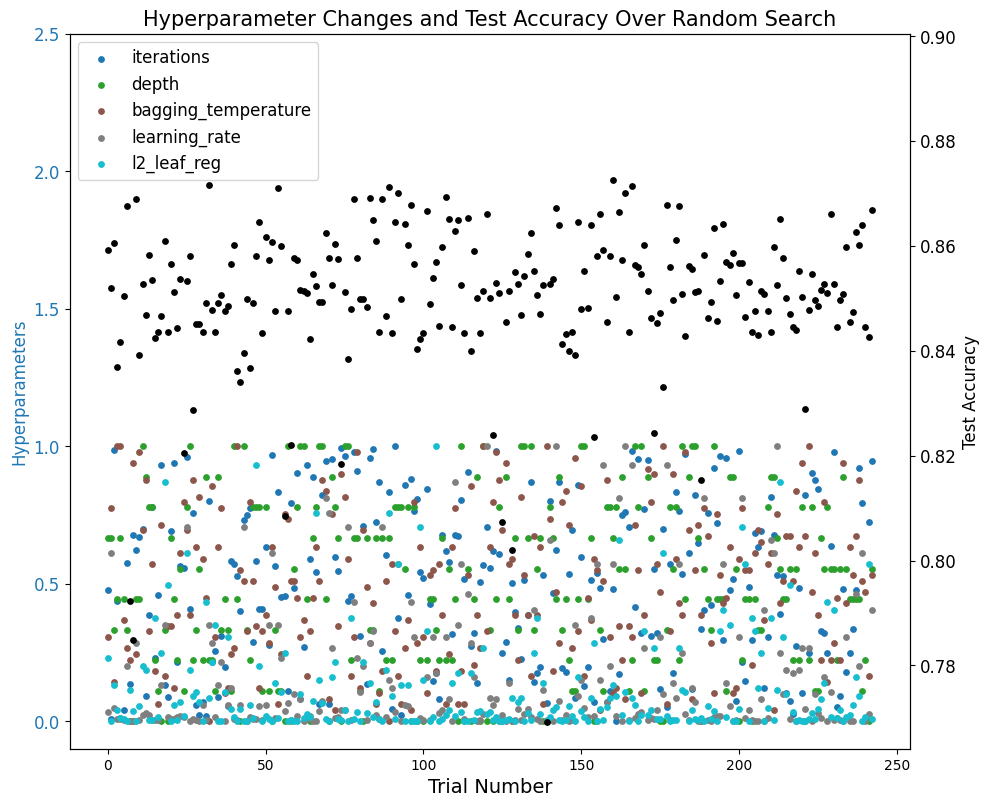

In [11]:
plot("Hyperparameter Changes and Test Accuracy Over Random Search", False, trial_data_random)